# Extract eval results - CIFAR

In [1]:
import sys
sys.path.append("./../")

In [2]:
import os
import json
import glob
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

#### Utility functions

In [3]:
# Accuracy threshold for models to be included in analysis
ACC_THRESHOLD = 0.75 # For CIFAR10

In [36]:
def extract_results(model_dir):
    """
        Get metrics from model dir
    """

    # Get config
    config_json = os.path.join(model_dir, 'config.json')
    config = json.load(open(config_json, 'r'))
    
    # Extract config values
    method = config['method']
    
    # Create a table entry for parameters  as string
    param_str = method # start with method label
    for _p, _p_value in config['method_params'].items():
        _p_value_str = None
        if isinstance(_p_value, int):
            _p_value_str = '{:04d}'.format(_p_value)
        elif isinstance(_p_value, float):
            _p_value_str = '{:08.3f}'.format(_p_value)
        else:
            _p_value_str = '{}'.format(_p_value)
        param_str += '-{}={}'.format(_p, _p_value_str)
    param = param_str
    
    results = None
    
    # Get result files
    ood_result_files = glob.glob(model_dir + "/ece_results_*.pkl")
    
    # Get results
    for rfile in ood_result_files:
        filename = os.path.basename(rfile)
        # Get corruption name from file name
        corr_name = ' '.join(filename.split('_')[2:])[:-4]
        # Split corruption name and identify severity
        severity = 3 # default
        _s = corr_name.split('-')
        if len(_s) > 1:
            corr_name = _s[0]
            severity = _s[1]
        with open(rfile, 'rb') as f:
            logs = pickle.load(f)[0]
            r = {
                'method': method,
                'params': param,
                'corruption': corr_name,
                'severity': severity,
                'ece': logs['ece_uncal_val'],
                'acc': logs['acc_val'],
                'nll': logs['nll_uncal_val'],
                'auroc': logs['auroc_val'],
                'ece_test': logs['ece_uncal_test'],
                'acc_test': logs['acc_test'],
                'nll_test': logs['nll_uncal_test'],
                'auroc_test': logs['auroc_test']
            }
            
            if results is not None:
                results.append(r)
            else:
                results = [r]
    
    return results

In [53]:
def extract_ood_results(model_dir, dataset_str='FMNIST'):
    """
        Get OOD metrics from model dir
    """

    # Get config
    config_json = os.path.join(model_dir, 'config.json')
    config = json.load(open(config_json, 'r'))
    
    # Extract config values
    method = config['method']
    
    # Create a table entry for parameters  as string
    param_str = method # start with method label
    for _p, _p_value in config['method_params'].items():
        _p_value_str = None
        if isinstance(_p_value, int):
            _p_value_str = '{:04d}'.format(_p_value)
        elif isinstance(_p_value, float):
            _p_value_str = '{:08.3f}'.format(_p_value)
        else:
            _p_value_str = '{}'.format(_p_value)
        param_str += '-{}={}'.format(_p, _p_value_str)
    param = param_str
    
    results = None
    
    # Get OOD result files
    ood_result_files = glob.glob(model_dir + "/ood_results_{}.pkl".format(dataset_str))
    
    assert len(ood_result_files) <= 1, "More than one OOD results exists"

    # Get accuracy on clean dataset also for quality checks
    acc_results_file = os.path.join(model_dir, "ece_results_identity-1.pkl")
    
    # Get results
    for rfile in ood_result_files:
        with open(acc_results_file, 'rb') as f:
            clean_results = pickle.load(f)[0]
        with open(rfile, 'rb') as f:
            logs = pickle.load(f)[0]
            r = {
                'method': method,
                'params': param,
                'ent_ood': logs['ent_ood'],
                'ent_test': logs['ent_test'],
                'ent_delta': logs['ent_delta'],
                'acc': clean_results['acc_val']
            }
            
            if results is not None:
                results.append(r)
            else:
                results = [r]
    
    return results

#### Specify experiments

In [38]:
# CIFAR10 + VGG11
result_dirs = [
    "./../zoo/multiclass-v2/sl/CIFAR10/VGG11",
    "./../zoo/multiclass-v2/mfvi/CIFAR10/VGG11",
    # "./../zoo/multiclass/ls/CIFAR10/VGG11",
    # "./../zoo/multiclass/edl/computed-prior/CIFAR10/VGG11EDL",
    # "./../zoo/multiclass/edl/skewed-prior/CIFAR10/VGG11EDL",
    "./../zoo/multiclass-v2/edl/CIFAR10/VGG11EDL"
]

#### Load results

In [39]:
# Enumerate model directories and load evaluation results
results = []
for models_root in result_dirs:
    model_dirs = list(map(lambda d: os.path.join(models_root, d), os.listdir(models_root)))
    for _m in model_dirs:
        results.extend(extract_results(_m))
df_results = pd.DataFrame(results)

In [40]:
# Do basic QA, ignore all models which fail to train satisfactorily
df_results = df_results[df_results.acc > ACC_THRESHOLD]

In [41]:
df_results

,method,params,corruption,severity,ece,acc,nll,auroc,ece_test,acc_test,nll_test,auroc_test
0,sl,sl-alpha=10000.000,speckle noise,5,0.080703,0.8288,0.677308,0.971820,0.186086,0.5609,1.854510,0.888605
1,sl,sl-alpha=10000.000,elastic transform,3,0.078373,0.8292,0.678017,0.971795,0.063587,0.7195,1.061652,0.949020
2,sl,sl-alpha=10000.000,fog,2,0.078548,0.8300,0.678198,0.971802,0.060584,0.7494,0.951868,0.955653
3,sl,sl-alpha=10000.000,pixelate,1,0.079089,0.8280,0.678726,0.971634,0.071821,0.8053,0.745756,0.967560
4,sl,sl-alpha=10000.000,shot noise,2,0.079752,0.8296,0.679272,0.971759,0.077543,0.7797,0.834448,0.959871
...,...,...,...,...,...,...,...,...,...,...,...,...
2395,edl,edl-annealing_step=1000,zoom blur,5,0.066924,0.8296,0.709863,0.965119,0.230750,0.5673,1.724330,0.838307
2396,edl,edl-annealing_step=1000,elastic transform,2,0.066926,0.8296,0.709856,0.965119,0.108717,0.7446,1.035141,0.930410
2397,edl,edl-annealing_step=1000,speckle noise,1,0.066926,0.8296,0.709856,0.965119,0.112636,0.7627,0.983423,0.940800
2398,edl,edl-annealing_step=1000,pixelate,5,0.066924,0.8296,0.709864,0.965119,0.156531,0.6939,1.249915,0.911250


## Get results for Clean dataset

In [42]:
df_clean = df_results[df_results.corruption == 'identity'].drop(['corruption'], axis=1).reset_index()
# df_clean = df_results.drop(['corruption'], axis=1).reset_index()

In [43]:
df_clean

,index,method,params,severity,ece,acc,nll,auroc,ece_test,acc_test,nll_test,auroc_test
0,19,sl,sl-alpha=10000.000,4,0.078690,0.8284,0.678288,0.971708,0.075677,0.8168,0.711688,0.969515
1,33,sl,sl-alpha=10000.000,2,0.082873,0.8286,0.677381,0.971825,0.075734,0.8169,0.711901,0.969543
2,40,sl,sl-alpha=10000.000,3,0.081384,0.8294,0.677355,0.971769,0.074295,0.8166,0.712434,0.969419
3,69,sl,sl-alpha=10000.000,5,0.078518,0.8292,0.679568,0.971716,0.075808,0.8178,0.711332,0.969580
4,88,sl,sl-alpha=10000.000,1,0.079945,0.8286,0.678010,0.971827,0.075142,0.8167,0.712283,0.969437
...,...,...,...,...,...,...,...,...,...,...,...,...
115,2319,edl,edl-annealing_step=1000,4,0.066925,0.8296,0.709864,0.965119,0.072697,0.8190,0.756114,0.961102
116,2333,edl,edl-annealing_step=1000,2,0.066925,0.8296,0.709864,0.965119,0.072697,0.8190,0.756114,0.961102
117,2340,edl,edl-annealing_step=1000,3,0.066925,0.8296,0.709863,0.965119,0.072697,0.8190,0.756114,0.961102
118,2369,edl,edl-annealing_step=1000,5,0.066925,0.8296,0.709864,0.965119,0.072697,0.8190,0.756114,0.961102


In [44]:
metrics_summ = df_clean.groupby('params').agg(
    n = pd.NamedAgg(column='acc', aggfunc='count'),
    acc_mean = pd.NamedAgg(column='acc', aggfunc='mean'),
    acc_err = pd.NamedAgg(column='acc', aggfunc=lambda x: np.std(x) / np.sqrt(x.shape[0])),
    ece_mean = pd.NamedAgg(column='ece', aggfunc='mean'),
    ece_err = pd.NamedAgg(column='ece', aggfunc=lambda x: np.std(x) / np.sqrt(x.shape[0])),
    nll_mean = pd.NamedAgg(column='nll', aggfunc='mean'),
    nll_err = pd.NamedAgg(column='nll', aggfunc=lambda x: np.std(x) / np.sqrt(x.shape[0])),
    auroc_mean = pd.NamedAgg(column='auroc', aggfunc='mean'),
    auroc_err = pd.NamedAgg(column='auroc', aggfunc=lambda x: np.std(x) / np.sqrt(x.shape[0])),
)

In [45]:
metrics_summ

,n,acc_mean,acc_err,ece_mean,ece_err,nll_mean,nll_err,auroc_mean,auroc_err
params,,,,,,,,,
edl-annealing_step=1000,20,0.826400,0.001234,0.061360,0.001557,0.719066,0.001509,0.963743,0.000324
mfvi,25,0.829144,0.000761,0.092497,0.001595,0.701787,0.008074,0.979923,0.000156
sl-alpha=0100.000,15,0.832653,0.000848,0.091009,0.001161,0.684624,0.006661,0.980815,0.000078
sl-alpha=0500.000,15,0.829800,0.000217,0.086990,0.003138,0.677544,0.011130,0.980124,0.000085
sl-alpha=1000.000,10,0.831680,0.000427,0.073439,0.000639,0.623954,0.001333,0.981392,0.000018
sl-alpha=10000.000,10,0.826180,0.000868,0.086172,0.001908,0.690274,0.003851,0.971397,0.000120
sl-alpha=5000.000,15,0.825787,0.000552,0.093488,0.004146,0.692055,0.004215,0.971602,0.000265
sl-alpha=50000.000,10,0.826840,0.000307,0.107188,0.006842,0.684586,0.004974,0.971067,0.000225


In [46]:
# For Table 1

nll_min = metrics_summ.nll_mean.min()
acc_max = metrics_summ.acc_mean.max()
auroc_max = metrics_summ.auroc_mean.max()
ece_min = metrics_summ.ece_mean.min()

for row in metrics_summ.itertuples():
    buffer = "{:50s}".format(row.Index)

    if row.nll_mean == nll_min:
        buffer += "& $\mathbf{{{:.3f} \pm {:.3f}}}$".format(row.nll_mean, row.nll_err)
    else:
        buffer += "&          ${:.3f} \pm {:.3f}$".format(row.nll_mean, row.nll_err)

    if row.acc_mean == acc_max:
        buffer += "& $\mathbf{{{:.3f} \pm {:.3f}}}$".format(row.acc_mean, row.acc_err)
    else:
        buffer += "&          ${:.3f} \pm {:.3f}$".format(row.acc_mean, row.acc_err)

    if row.auroc_mean == auroc_max:
        buffer += "& $\mathbf{{{:.3f} \pm {:.3f}}}$".format(row.auroc_mean, row.auroc_err)
    else:
        buffer += "&          ${:.3f} \pm {:.3f}$".format(row.auroc_mean, row.auroc_err)

    if row.ece_mean == ece_min:
        buffer += "& $\mathbf{{{:.3f} \pm {:.3f}}}$".format(row.ece_mean, row.ece_err)
    else:
        buffer += "&          ${:.3f} \pm {:.3f}$".format(row.ece_mean, row.ece_err)

    print(buffer)

edl-annealing_step=1000                           &          $0.719 \pm 0.002$&          $0.826 \pm 0.001$&          $0.964 \pm 0.000$& $\mathbf{0.061 \pm 0.002}$
mfvi                                              &          $0.702 \pm 0.008$&          $0.829 \pm 0.001$&          $0.980 \pm 0.000$&          $0.092 \pm 0.002$
sl-alpha=0100.000                                 &          $0.685 \pm 0.007$& $\mathbf{0.833 \pm 0.001}$&          $0.981 \pm 0.000$&          $0.091 \pm 0.001$
sl-alpha=0500.000                                 &          $0.678 \pm 0.011$&          $0.830 \pm 0.000$&          $0.980 \pm 0.000$&          $0.087 \pm 0.003$
sl-alpha=1000.000                                 & $\mathbf{0.624 \pm 0.001}$&          $0.832 \pm 0.000$& $\mathbf{0.981 \pm 0.000}$&          $0.073 \pm 0.001$
sl-alpha=10000.000                                &          $0.690 \pm 0.004$&          $0.826 \pm 0.001$&          $0.971 \pm 0.000$&          $0.086 \pm 0.002$
sl-alpha=5000.000     

#### Get results for test dataset

In [47]:
metrics_summ_test = df_clean.groupby('params').agg(
    n = pd.NamedAgg(column='acc_test', aggfunc='count'),
    acc_mean = pd.NamedAgg(column='acc_test', aggfunc='mean'),
    acc_err = pd.NamedAgg(column='acc_test', aggfunc=lambda x: np.std(x) / np.sqrt(x.shape[0])),
    ece_mean = pd.NamedAgg(column='ece_test', aggfunc='mean'),
    ece_err = pd.NamedAgg(column='ece_test', aggfunc=lambda x: np.std(x) / np.sqrt(x.shape[0])),
    nll_mean = pd.NamedAgg(column='nll_test', aggfunc='mean'),
    nll_err = pd.NamedAgg(column='nll_test', aggfunc=lambda x: np.std(x) / np.sqrt(x.shape[0])),
    auroc_mean = pd.NamedAgg(column='auroc_test', aggfunc='mean'),
    auroc_err = pd.NamedAgg(column='auroc_test', aggfunc=lambda x: np.std(x) / np.sqrt(x.shape[0])),
)

In [48]:
metrics_summ_test

,n,acc_mean,acc_err,ece_mean,ece_err,nll_mean,nll_err,auroc_mean,auroc_err
params,,,,,,,,,
edl-annealing_step=1000,20,0.816350,0.000564,0.071344,0.001445,0.764149,0.001978,0.959818,0.000213
mfvi,25,0.819244,0.000754,0.101343,0.001305,0.762771,0.009417,0.977689,0.000145
sl-alpha=0100.000,15,0.825133,0.000580,0.099637,0.000170,0.746004,0.003741,0.978480,0.000085
sl-alpha=0500.000,15,0.819587,0.000595,0.098235,0.003400,0.731637,0.011455,0.978515,0.000177
sl-alpha=1000.000,10,0.820890,0.001510,0.084952,0.003342,0.679737,0.007465,0.979366,0.000217
sl-alpha=10000.000,10,0.815180,0.000576,0.081904,0.002085,0.727084,0.004795,0.968557,0.000298
sl-alpha=5000.000,15,0.819700,0.000825,0.087610,0.004711,0.713723,0.002946,0.970003,0.000044
sl-alpha=50000.000,10,0.818050,0.000191,0.101874,0.007770,0.709586,0.007784,0.969890,0.000448


In [49]:
def get_prefix(x):
    parts = x.split('-')
    if len(parts) < 2:
        return '-'.join(parts)
    else:
        return '-'.join(parts[:-1])

# Find groups of experiments without looking at last param
unique_prefixes = list(sorted(set(
        list(map(get_prefix, metrics_summ.index))
    )))

# For each of the unique prefixes, find the best in validation group according to
# NLL
r = []
for pfx in unique_prefixes:
    _df_val = metrics_summ[metrics_summ.index.str.startswith(pfx)]
    idx = _df_val.nll_mean.idxmin()

    # Now get the corresponding results from test set
    r.append(metrics_summ_test.loc[idx])

df_nll_best = pd.DataFrame(r)

In [50]:
unique_prefixes

['edl', 'mfvi', 'sl']

In [51]:
nll_min = df_nll_best.nll_mean.min()
acc_max = df_nll_best.acc_mean.max()
auroc_max = df_nll_best.auroc_mean.max()
ece_min = df_nll_best.ece_mean.min()

for row in df_nll_best.itertuples():
    buffer = "{:50s}".format(row.Index)

    if row.nll_mean == nll_min:
        buffer += " & $\mathbf{{{:.3f} \pm {:.3f}}}$".format(row.nll_mean, row.nll_err)
    else:
        buffer += " &          ${:.3f} \pm {:.3f}$".format(row.nll_mean, row.nll_err)

    if row.acc_mean == acc_max:
        buffer += " & $\mathbf{{{:.3f} \pm {:.3f}}}$".format(row.acc_mean, row.acc_err)
    else:
        buffer += " &          ${:.3f} \pm {:.3f}$".format(row.acc_mean, row.acc_err)

    if row.auroc_mean == auroc_max:
        buffer += " & $\mathbf{{{:.3f} \pm {:.3f}}}$".format(row.auroc_mean, row.auroc_err)
    else:
        buffer += " &          ${:.3f} \pm {:.3f}$".format(row.auroc_mean, row.auroc_err)

    if row.ece_mean == ece_min:
        buffer += " & $\mathbf{{{:.3f} \pm {:.3f}}}$".format(row.ece_mean, row.ece_err)
    else:
        buffer += " &          ${:.3f} \pm {:.3f}$".format(row.ece_mean, row.ece_err)

    print(buffer)

edl-annealing_step=1000                            &          $0.764 \pm 0.002$ &          $0.816 \pm 0.001$ &          $0.960 \pm 0.000$ & $\mathbf{0.071 \pm 0.001}$
mfvi                                               &          $0.763 \pm 0.009$ &          $0.819 \pm 0.001$ &          $0.978 \pm 0.000$ &          $0.101 \pm 0.001$
sl-alpha=1000.000                                  & $\mathbf{0.680 \pm 0.007}$ & $\mathbf{0.821 \pm 0.002}$ & $\mathbf{0.979 \pm 0.000}$ &          $0.085 \pm 0.003$


## OOD Results

In [54]:
# Enumerate model directories and load evaluation results
ood_results = []
for models_root in result_dirs:
    model_dirs = list(map(lambda d: os.path.join(models_root, d), os.listdir(models_root)))
    for _m in model_dirs:
        ood_results.extend(extract_ood_results(_m, dataset_str='SVHN'))
df_ood_results = pd.DataFrame(ood_results)

In [55]:
df_ood_results

,method,params,ent_ood,ent_test,ent_delta,acc
0,sl,sl-alpha=10000.000,0.787462,0.615284,0.172178,0.8286
1,sl,sl-alpha=0100.000,0.687135,0.211818,0.475317,0.8368
2,sl,sl-alpha=1000.000,0.664705,0.239418,0.425287,0.8330
3,sl,sl-alpha=10000.000,0.805800,0.638227,0.167572,0.8232
4,sl,sl-alpha=50000.000,1.029140,0.797054,0.232086,0.8270
5,sl,sl-alpha=0100.000,0.667052,NaN,NaN,0.8298
6,sl,sl-alpha=0500.000,0.652778,0.202114,0.450664,0.8292
7,sl,sl-alpha=5000.000,0.751232,0.594910,0.156322,0.8250
8,sl,sl-alpha=0100.000,0.812664,NaN,NaN,0.8312
9,sl,sl-alpha=0500.000,0.870974,0.279095,0.591879,0.8308


In [56]:
df_ood_results = df_ood_results[df_ood_results.acc > ACC_THRESHOLD]

In [57]:
ood_metrics_summ = df_ood_results.groupby('params').agg(
    n = pd.NamedAgg(column='ent_ood', aggfunc='count'),
    ent_ood_mean = pd.NamedAgg(column='ent_ood', aggfunc='mean'),
    ent_ood_err = pd.NamedAgg(column='ent_ood', aggfunc=lambda x: np.std(x) / np.sqrt(x.shape[0])),
    ent_test_mean = pd.NamedAgg(column='ent_test', aggfunc='mean'),
    ent_test_err = pd.NamedAgg(column='ent_test', aggfunc=lambda x: np.std(x) / np.sqrt(x.shape[0])),
    ent_delta_mean = pd.NamedAgg(column='ent_delta', aggfunc='mean'),
    ent_delta_err = pd.NamedAgg(column='ent_delta', aggfunc=lambda x: np.std(x) / np.sqrt(x.shape[0])),
    ent_acc_mean = pd.NamedAgg(column='acc', aggfunc='mean'),
    ent_acc_err = pd.NamedAgg(column='acc', aggfunc=lambda x: np.std(x) / np.sqrt(x.shape[0])),
)

In [58]:
ood_metrics_summ

,n,ent_ood_mean,ent_ood_err,ent_test_mean,ent_test_err,ent_delta_mean,ent_delta_err,ent_acc_mean,ent_acc_err
params,,,,,,,,,
edl-annealing_step=1000,4,1.121965,0.116595,0.498080,0.015923,0.623885,0.101764,0.826400,0.002760
mfvi,5,0.664364,0.033979,0.222745,0.013222,0.441619,0.036024,0.829160,0.001706
sl-alpha=0100.000,3,0.722283,0.037200,0.211818,0.000000,0.475317,0.000000,0.832600,0.001746
sl-alpha=0500.000,3,0.720418,0.061570,0.227252,0.021168,0.493165,0.040429,0.830000,0.000377
sl-alpha=1000.000,2,0.734579,0.049408,0.239418,0.000000,0.425287,0.000000,0.831600,0.000990
sl-alpha=10000.000,2,0.796631,0.006483,0.626756,0.008112,0.169875,0.001628,0.825900,0.001909
sl-alpha=5000.000,3,0.770060,0.016309,0.602889,0.006049,0.167171,0.010290,0.826133,0.001533
sl-alpha=50000.000,2,0.947161,0.057967,0.715118,0.057937,0.232044,0.000030,0.826100,0.000636


In [84]:
def get_prefix(x):
    parts = x.split('-')
    if len(parts) < 2:
        return '-'.join(parts)
    else:
        return '-'.join(parts[:-1])

# Find groups of experiments without looking at last param
unique_prefixes = list(sorted(set(
        list(map(get_prefix, ood_metrics_summ.index))
    )))

# For each of the unique prefixes, find the best in validation group according to
# NLL and printout the entropy in OOD
r = []
for pfx in unique_prefixes:
    _df_val = metrics_summ[metrics_summ.index.str.startswith(pfx)]
    idx = _df_val.nll_mean.idxmin()

    # Now get the corresponding results from OOD set
    r.append(ood_metrics_summ.loc[idx])

df_ood_best = pd.DataFrame(r)

In [85]:
df_ood_best

,n,ent_ood_mean,ent_ood_err,ent_test_mean,ent_test_err,ent_delta_mean,ent_delta_err,ent_acc_mean,ent_acc_err
edl-annealing_step=1000,4.0,1.121965,0.116595,0.498080,0.015923,0.623885,0.101764,0.82640,0.002760
mfvi,5.0,0.664364,0.033979,0.222745,0.013222,0.441619,0.036024,0.82916,0.001706
sl-alpha=1000.000,2.0,0.734579,0.049408,0.239418,0.000000,0.425287,0.000000,0.83160,0.000990


In [86]:
# Table - Results OOD
ent_delta_max = df_ood_best.ent_delta_mean.max()

for row in df_ood_best.itertuples():
    buffer = "{:50s}".format(row.Index)

    # In-domain entropy
    buffer += "& ${:.3f} \pm {:.3f}$".format(row.ent_test_mean, row.ent_test_err)

    # OOD entropy
    buffer += "& ${:.3f} \pm {:.3f}$".format(row.ent_ood_mean, row.ent_ood_err)

    if row.ent_delta_mean == ent_delta_max:
        buffer += "& $\mathbf{{{:.3f} \pm {:.3f}}}$".format(row.ent_delta_mean, row.ent_delta_err)
    else:
        buffer += "&          ${:.3f} \pm {:.3f}$".format(row.ent_delta_mean, row.ent_delta_err)

    print(buffer)

edl-annealing_step=1000                           & $0.498 \pm 0.016$& $1.122 \pm 0.117$& $\mathbf{0.624 \pm 0.102}$
mfvi                                              & $0.223 \pm 0.013$& $0.664 \pm 0.034$&          $0.442 \pm 0.036$
sl-alpha=1000.000                                 & $0.239 \pm 0.000$& $0.735 \pm 0.049$&          $0.425 \pm 0.000$


## Get results for Corrupted dataset

In [87]:
df_corrupted = df_results[df_results.corruption != 'identity'].reset_index().drop(['index'], axis=1)

In [104]:
# Get the best method with NLL with each algorithm
def get_prefix(x):
    parts = x.split('-')
    if len(parts) < 2:
        return '-'.join(parts)
    else:
        return '-'.join(parts[:1])
    # return parts[0]

# Find groups of experiments without looking at last param
unique_prefixes = list(sorted(set(
        list(map(get_prefix, metrics_summ.index))
    )))

# For each of the unique prefixes, find the best in validation group according to
# NLL
r = []
for pfx in unique_prefixes:
    _df_val = metrics_summ[metrics_summ.index.str.startswith(pfx)]
    idx = _df_val.nll_mean.idxmin()

    # Now get the corresponding results from test set
    r.append(metrics_summ_test.loc[idx])

df_nll_best_config = pd.DataFrame(r)

In [105]:
df_nll_best_config

,n,acc_mean,acc_err,ece_mean,ece_err,nll_mean,nll_err,auroc_mean,auroc_err
edl-annealing_step=1000,20.0,0.816350,0.000564,0.071344,0.001445,0.764149,0.001978,0.959818,0.000213
mfvi,25.0,0.819244,0.000754,0.101343,0.001305,0.762771,0.009417,0.977689,0.000145
sl-alpha=1000.000,10.0,0.820890,0.001510,0.084952,0.003342,0.679737,0.007465,0.979366,0.000217


In [106]:
# Get the result for best configuration in family
df_corrupted_test = df_corrupted[df_corrupted.params.isin(df_nll_best_config.index.tolist())].reset_index(drop=True)

In [107]:
gdf_corrupted_ece_mean = df_corrupted_test[
    ['corruption', 'method', 'ece_test', 'nll_test', 'acc_test']
].groupby(['corruption', 'method']).mean()

df = gdf_corrupted_ece_mean.reset_index()
df.method = df.method.str.upper()
df = df.rename(columns={'ece_test': 'ECE', 'corruption': 'Corruption', 'method': 'Method'})

df['Method'] = df['Method'].replace(['SL'], 'Proposed')
df['Method'] = df['Method'].replace(['LS'], 'Label Smoothing')
df['Method'] = df['Method'].replace(['MFVI'], 'ELBO')

### Overall corrupted

##### ECE

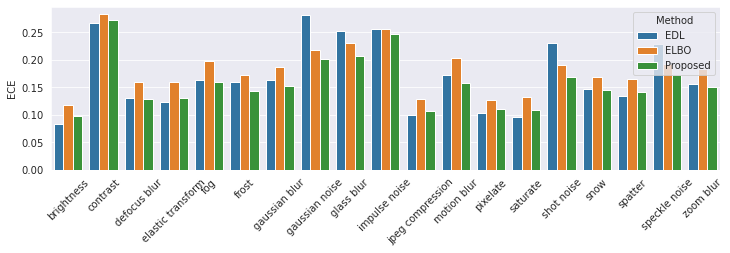

In [109]:
fig = plt.figure(figsize=(12, 3))
g = sns.barplot(x='Corruption', y='ECE', hue='Method', 
            data=df)
_ = g.set_xticklabels(g.get_xticklabels(), rotation=45)
_ = g.set_xlabel("")
_ = g.set_ylabel("ECE")

##### NLL

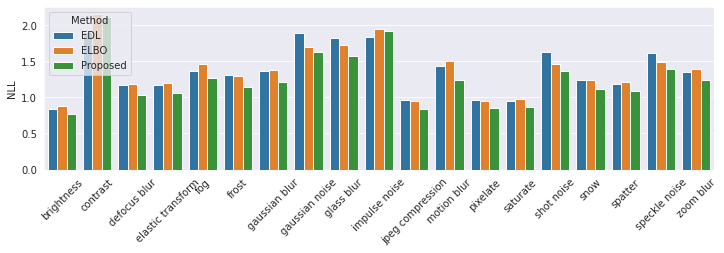

In [110]:
fig = plt.figure(figsize=(12, 3))
g = sns.barplot(x='Corruption', y='nll_test', hue='Method', 
            data=df)
_ = g.set_xticklabels(g.get_xticklabels(), rotation=45)
_ = g.set_xlabel("")
_ = g.set_ylabel("NLL")

##### Accuracy

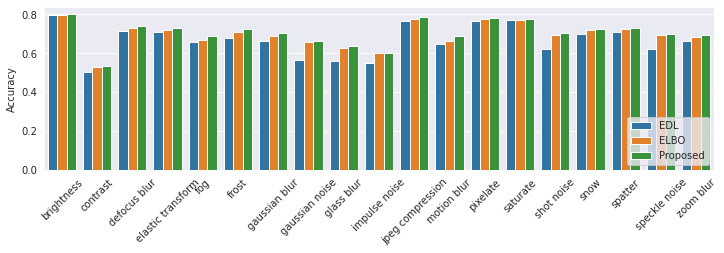

In [111]:
# Prepare data frame
fig = plt.figure(figsize=(12, 3))
g = sns.barplot(x='Corruption', y='acc_test', hue='Method', 
            data=df)
_ = g.set_xticklabels(g.get_xticklabels(), rotation=45)
_ = g.set_xlabel("")
# _ = g.set_ylim(0.5, 1.0)
_ = g.set_ylabel("Accuracy")
_ = g.legend(loc='lower right')

### Level-wise corrupted

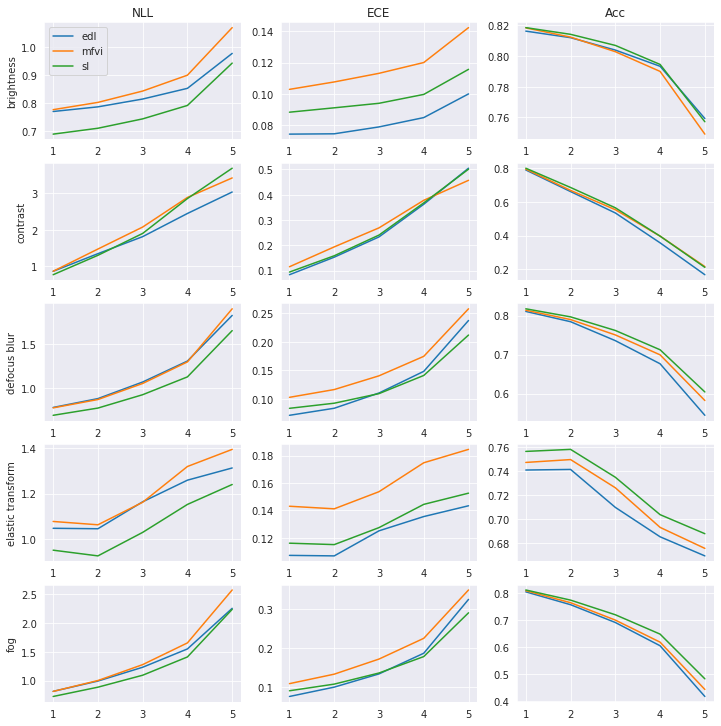

In [160]:
corruptions = sorted(df.corruption.unique())[:5]
n = len(corruptions)

df = df_corrupted_test[df_corrupted_test.corruption.isin(corruptions)]

fig, ax = plt.subplots(n, 3, figsize=(3*4, n*2.5))

gdf_corruption = df.groupby(by='corruption')

for i, (_corr, _df) in enumerate(gdf_corruption):
    gdf_method = _df.groupby(by='method')
    for _method, _df_method in gdf_method:
        _r = _df_method.groupby(by='severity').mean()

        # Plot NLL
        ax[i, 0].plot(_r.index, _r.nll_test, label=_method)

        # Plot ECE
        ax[i, 1].plot(_r.index, _r.ece_test, label=_method)

        # Plot Acc
        ax[i, 2].plot(_r.index, _r.acc_test, label=_method)

    # Fix labels
    if i == 0:
        ax[i, 0].legend()
        ax[i, 0].set_title("NLL")
        ax[i, 1].set_title("ECE")
        ax[i, 2].set_title("Acc")
    ax[i, 0].set_ylabel(_corr)
